In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pad_packed_sequence, pack_padded_sequence

### Import Data

In [306]:
train = pd.read_csv("s3://advancedml-koch-mathur-hinkson/train.csv")

In [307]:
train.shape

(1804874, 45)

### Divide Dataset into Train and Validation/ Test Set

In [309]:
train['label'] = train.target.apply(lambda x: 1 if x > 0.5 else 0)
msk = np.random.rand(len(train)) < 0.8
train_set = train[msk]
validation_set = train[~msk]


In [312]:
print(train_set.label.value_counts(normalize=True))

0    0.941128
1    0.058872
Name: label, dtype: float64


In [313]:
print(validation_set.label.value_counts(normalize=True))

0    0.940624
1    0.059376
Name: label, dtype: float64


In [349]:
msk_test = np.random.rand(len(validation_set)) <= 0.50
test_set = validation_set[~msk_test]
validation_set = validation_set[msk_test]

In [350]:
print(validation_set.label.value_counts(normalize=False))
print(test_set.label.value_counts(normalize=False))

0    169545
1     10755
Name: label, dtype: int64
0    169895
1     10672
Name: label, dtype: int64


### Create Training Sets

Use different percetages of available data, with various proportions of toxic comments

#### Take 20%, 30%, 40%, 50%, and 60% of data

In [315]:
train_sample = train_set.sample(frac=0.2, replace=True)
print(train_sample.label.value_counts(normalize=True))

0    0.941129
1    0.058871
Name: label, dtype: float64


In [332]:
train_sample30 = train_set.sample(frac=0.3, replace=True)
print(train_sample30.label.value_counts(normalize=True))

0    0.941291
1    0.058709
Name: label, dtype: float64


In [333]:
train_sample40 = train_set.sample(frac=0.4, replace=True)
print(train_sample30.label.value_counts(normalize=True))

0    0.941291
1    0.058709
Name: label, dtype: float64


In [334]:
train_sample50 = train_set.sample(frac=0.5, replace=True)
print(train_sample30.label.value_counts(normalize=True))

0    0.941291
1    0.058709
Name: label, dtype: float64


In [335]:
train_sample60 = train_set.sample(frac=0.6, replace=True)
print(train_sample30.label.value_counts(normalize=True))

0    0.941291
1    0.058709
Name: label, dtype: float64


#### Rebalance Data Set

Create "weighted" datasets with increased rate of toxic comments 

In [320]:
toxic = train_sample[train_sample.label == 1]
nontoxic = train_sample[train_sample.label == 0]

In [321]:
train_sample.shape, toxic.shape, nontoxic.shape

((288801, 46), (17002, 46), (271799, 46))

In [324]:
TOTAL_TOXIC = len(toxic)
TOTAL_TOXIC

17002

In [340]:
prepared_25 = toxic.append(nontoxic.sample(TOTAL_TOXIC*3))
prepared_25 = prepared_25.sample(frac=1).reset_index(drop=True)
print("prepared_25:\n", prepared_25.label.value_counts())

prepared_50 = toxic.append(toxic).append(nontoxic.sample(TOTAL_TOXIC*2))
prepared_50 = prepared_50.sample(frac=1).reset_index(drop=True)
print("prepared_50:\n", prepared_50.label.value_counts())

prepared_75 = toxic.append(toxic).append(toxic).append(nontoxic.sample(TOTAL_TOXIC))
prepared_75 = prepared_75.sample(frac=1).reset_index(drop=True)
print("prepared_75:\n", prepared_75.label.value_counts())

prepared_25:
 0    51006
1    17002
Name: label, dtype: int64
prepared_50:
 1    34004
0    34004
Name: label, dtype: int64
prepared_75:
 1    51006
0    17002
Name: label, dtype: int64


#### Confirm datasets are same size

In [339]:
print(prepared_25.shape, prepared_50.shape, prepared_75.shape)

(68008, 46) (68008, 46) (68008, 46)


#### Create Random Dataset

To evaluate the efficacy of imbalance correction, we generate a completely random dataset of comparative size as a control.

In [325]:
random_df = train_sample.sample(TOTAL_TOXIC*4)

In [337]:
print(random_df.shape)

(68008, 46)


#### Add cleaned column to datasets

In [345]:
import re
import time
import pandas as pd
import string


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer


def print_elapsed_time(start, end, message):
    print(f"{message}...Elapsed Time:{round((end - start)/60,3)} minutes")

# intialize stemmer
ps = PorterStemmer() 
ls = LancasterStemmer()

# define stopwords
stops = set(stopwords.words('english'))
stops.add('')

approved_stop_words = {"not", "get", "against", "haven", "haven't","aren't", 
                       "aren", "should", "shouldn", "shouldn't", "themselves", 
                       "them", "under", "over", 'won', "won't", "wouldn'", 
                       "wouldn't"}

stops = stops - approved_stop_words

def clean_text(text, stop_ws=stops, stemmer=ps, str_output=True):
    
    t = text.replace("-", " ").split(" ")
    t = [w.strip(string.punctuation) for w in t]
    
    if stop_ws:
        t = [w.lower() for w in t if w not in stop_ws]
    
    if stemmer:
        t = [stemmer.stem(w) for w in t]
    
    if str_output:
        return ' '.join(t)
    else:
        return t



In [347]:
for df in [prepared_25, prepared_50, prepared_75]:
    df['cleaned_no_stem'] = df["comment_text"].apply(clean_text,args=(stops,None,False),)

In [348]:
prepared_50.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,label,cleaned_no_stem
0,254975,0.000000,garycrum - No erasing needed as Mr Trump spoke...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,0,0,0,1,0,0.0,0,4,0,"[garycrum, no, erasing, needed, mr, trump, spo..."
1,6212918,0.200000,Was Jesus conceived of EGG and Sperm. Seems o...,0.000000,0.000000,0.200000,0.100000,0.0,0.0,0.0,...,0,0,0,0,0,0.1,10,10,0,"[was, jesus, conceived, egg, sperm, seems, myt..."
2,724109,0.857143,That's because you're too dumb to understand t...,0.085714,0.128571,0.457143,0.842857,0.0,0.0,0.0,...,0,0,0,2,1,0.0,6,70,1,"[that's, dumb, understand, data, bob, you're, ..."
3,6204777,1.000000,yeah! \n\nI loved that stat.\n\nI own 100 guns...,0.000000,0.000000,0.000000,0.000000,1.0,NaN,NaN,...,0,0,0,0,1,0.0,0,4,1,"[yeah, \n\ni, loved, stat.\n\ni, 100, guns, i,..."
4,6319321,0.000000,"My post, below, makes the point that conservat...",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,1,0,0.0,4,4,0,"[my, post, makes, point, conservative, blindne..."


#### Use 10K dataset for initial build

In [257]:
mini_preprocessed = pd.read_pickle('mini_preprocessed.pkl')

mini_preprocessed.head().style

In [12]:
assign_label = lambda x: 0 if x < 0.5 else 1


In [259]:
mini_preprocessed['label'] = mini_preprocessed.target.apply(lambda x: assign_label(x))


## Build LSTM

In [351]:
TOXIC_LABEL = 'toxic'
NOT_TOXIC_LABEL = 'not_toxic'  
VOCAB_SIZE = 7500

In [352]:
import torch
import torch.utils.data as tud

from collections import Counter, defaultdict

class TextData:
    def __init__(self, df, text_col='cleaned_no_stem'):
        # pull relevant data from df
        self.preprocessed_text = [word_list for word_list in df[text_col] ]
        
        # gather vocabulary corpus to store all words in training data
        self.vocab = Counter([word for comment in self.preprocessed_text 
                              for word in comment]
                            ).most_common(VOCAB_SIZE-1)

        # word to index mapping
        self.word_to_idx = {k[0]: v+1 for v, k in 
                            enumerate(self.vocab)}
        # all the unknown words will be mapped to index 0
        self.word_to_idx["UNK"] = 0 
        self.idx_to_word = {v:k for k, v in self.word_to_idx.items()}
        self.label_to_idx = {TOXIC_LABEL: 1, NOT_TOXIC_LABEL: 0}
        self.idx_to_label = [NOT_TOXIC_LABEL, TOXIC_LABEL]
        self.vocab = set(self.word_to_idx.keys())


### Initial LSTM

In [353]:
from torch import optim
import math
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, X_data, y_data, test_X, test_y, hidden_dim, batch_size=1,   
                 embed_dim=6, weight_decay=0, optimizer_fcn='Adam', 
                 learning_rate=1e-3, num_layers=2, dropout=0.05, num_classes=2):
        super(LSTMModel, self).__init__()
        nn.Module.__init__(self)
        TextData.__init__(self, X_data)  
        self.vocab_size = VOCAB_SIZE
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.output_dim = num_classes
        self.loss_fcn = nn.NLLLoss()
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.highest_f1 = -math.inf
 
        # Layer 1: Embedding Layer
        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim)
    
        # Layer 2: LSTM Layer
        self.lstm = nn.LSTM(input_size = self.embed_dim, hidden_size = self.hidden_dim, 
                            num_layers = self.num_layers, dropout = self.dropout, batch_first=True)
        
        # Layer 3 (Output Layer): Linear
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        # define optimizer
        if optimizer_fcn == 'Adam':
            self.optimizer = optim.Adam(params=self.parameters(),
                                                 weight_decay=self.weight_decay,
                                                 lr=self.learning_rate)
        elif optimizer_fcn == 'RMSprop':
            self.optimizer = optim.RMSprop(params=self.parameters(), 
                                                 weight_decay=self.weight_decay,
                                                 lr=self.learning_rate)
        elif optimizer_fcn == 'SDG':
            self.optimizer = optim.SGD(params=self.parameters(), 
                                                 weight_decay=self.weight_decay,
                                                 lr=self.learning_rate)

    def forward(self, input_seq):

        embed_out = self.embedding(input_seq)

        lstm_out, (hn, cn) = self.lstm(embed_out)
         
        out = F.log_softmax(self.linear(hn), dim=self.output_dim)

        return out

    
    def get_vectors(self, labels, text=None, text_col=None):    
        X = []
        if text is None:
            text = self.preprocessed_text
        else:
            text = text[text_col]
        for comment in text:
            X.append( 
                torch.tensor([self.word_to_idx.get(w, 0) for w in comment])
            )
        X_tensors = pad_sequence(X, batch_first=True)

        y_tensors = pd.get_dummies(labels).values
        y_tensors = torch.LongTensor(y_tensors)
            
        return X_tensors, y_tensors

    
    def classify(self, X_vec):
        '''
        This function classifies documents into their categories. 
        docs are documents without labels.
        '''
        # pass to forwrard --> get two items. first value is 
        # not toxic class and second is toxic class
        argmaxes = []
        for vec in X_vec:

            results = self.forward(vec.unsqueeze(0))
            
            _, indices = torch.max(results.view(-1, results.size()[-1]), argmax=1)
            # indicies works cleanest --> for multiclass, look up in self.label_to_idx
            argmaxes.append(indices.item())
        
        return argmaxes
            
        
    def evaluate_classifier(self, validation_X, validation_y, text_col=None):
        '''
        This function evaluates the data with the current model. 
        data contains both documents and labels. 
        It calls classify() to make predictions, 
        and compares with the correct labels to return 
        the model accuracy on "data". 
        '''
        X_vec, y_vec = self.get_vectors(validation_y, text=validation_X, 
                                        text_col='cleaned_no_stem')

        labels = [(single_tensor[1]).unsqueeze(0).item() for single_tensor in y_vec]
        
        classifications = self.classify(X_vec)

        accuracy = accuracy_score(labels, classifications)
        print(f"Accuracy: {round(accuracy, 5)}")
        
        precision = precision_score(labels, classifications)
        print(f"Precision: {round(precision, 5)}")
        
        recall = recall_score(labels, classifications)
        print(f"Recall: {round(recall, 5)}")
        
        auc_roc = roc_auc_score(labels, classifications)
        print(f"AUC-ROC: {round(auc_roc, 5)}")
        
        f1 = f1_score(labels, classifications)
        print("Model Metrics:")
        print(f"F1 Score: {round(f1, 5)}; Precision: {round(precision, 5)}; "
              "Recall: {round(recall, 5)}; AUC-ROC: {round(auc_roc, 5)}; Accuracy: {round(accuracy, 5)}")
        
        self.overall_metrics = {
            'f1': f1,
            'precision': precision,
            'auc_roc': auc_roc,
            'recall': recall,
            'accuracy': accuracy
        }
        
        results_df = validation_X.copy()
        results_df['predicted_score'] = classifications
        results_df['y_true'] = labels
        results_df['accuracy'] = results_df.predicted_score == results_df.y_true
        
        return f1, results_df
    
    
    def run_model(self, y_data, test_X, test_y, num_epochs, loss_record, text_col=None):
        
        X_vec, y_vec = self.get_vectors(y_data, text=None)
        last_mean_error = -math.inf
        training_samples = X_vec.size()[0]
        for epoch in range(num_epochs):

            for i in range(training_samples):
                # Zero out gradient, else they will accumulate between epochs
                self.optimizer.zero_grad()
                
                y_pred = self.forward(X_vec[i].unsqueeze(0))

                loss = self.loss_fcn(input=y_pred.view(-1, y_pred.size()[-1]), 
                                     target=(y_vec[i][1]).unsqueeze(0))
                
                # Backward pass
                loss.backward()

                # Update parameters
                self.optimizer.step()
            
            thresholds: {
                5000: 1000, 
                1000: 100, 
                100: 10, 
                20: 5, 
                10: 3
            }
            
            # print results for every few epochs
            if epoch % thresholds[num_epochs] == 0:
                print(f"Epoch {epoch}, Negative Log Linear Loss: {loss.item()}")
                loss_record[epoch] = loss.item()
                
                with torch.no_grad():
                    if np.mean(np.abs(loss.item())) < last_mean_error:
                        print(f"Delta after {epoch} iterations: {np.mean(np.abs(loss.item()))}")
                        last_mean_error = np.mean(np.abs(loss.item()))
                    else:
                        if last_mean_error > -math.inf:
                            print(f"Break: {np.mean(np.abs(loss.item()))} > {last_mean_error}")
                            break
                
        print()
        print("Starting Evaluation")
        print(f"Epochs: {num_epochs}; Train Size: {training_samples}; Test Size: {test_X.shape[0]})")
        
        model_f1, results_df = self.evaluate_classifier(test_X, test_y, text_col=text_col)
            
        best_model_state_dict = None
        
        if model_f1 > self.highest_f1:
            self.highest_f1 = model_f1
            
            best_model_state_dict = self.state_dict() 
        
        return results_df, best_model_state_dict

### Split Data

In [237]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mini_preprocessed.drop('label', axis=1), 
                                                    mini_preprocessed['label'], 
                                                    test_size = 0.20, 
                                                    random_state = 4812)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(8000, 60) (8000,)
(2000, 60) (2000,)


In [226]:
y_train.value_counts(normalize=True)

0    0.9435
1    0.0565
Name: label, dtype: float64

In [227]:
y_test.value_counts(normalize=True)

0    0.937
1    0.063
Name: label, dtype: float64

In [228]:
mini_preprocessed[['cleaned_no_stem', 'label']].head()

,cleaned_no_stem,label
0,"[this, cool, it's, like, would, want, mother, ...",0
1,"[thank, this, would, make, life, lot, less, an...",0
2,"[this, urgent, design, problem, kudos, taking,...",0
3,"[is, something, i'll, able, install, site, whe...",0
4,"[haha, guys, bunch, losers]",1


In [162]:
# get max number of words after cleaning
max(mini_preprocessed['cleaned_no_stem'].apply(len))

194

In [163]:
# get min nonzero length 
min(mini_preprocessed.loc[mini_preprocessed['cleaned_no_stem'].apply(len)>0, 
                          'cleaned_no_stem'].apply(len))

1

### Initial Pytorch LSTM Implementation

In [238]:
lstm_model = LSTMModel(X_train, y_train, X_test, y_test, hidden_dim=3,
              num_layers=1, embed_dim=6, batch_size=1, dropout=0, num_classes=2)

In [239]:
lstm_model.train()

LSTMModel(
  (loss_fcn): NLLLoss()
  (embedding): Embedding(7500, 6)
  (lstm): LSTM(6, 3, batch_first=True)
  (linear): Linear(in_features=3, out_features=2, bias=True)
)

In [231]:
NUM_EPOCHS = 1
hist = np.zeros(NUM_EPOCHS)

In [232]:
results, model_state_dict = lstm_model.run_model(y_train, X_test, y_test, NUM_EPOCHS, 
                     hist, text_col='cleaned_no_stem')

Epoch 0, Negative Log Linear Loss: 0.05140280723571777

Starting Evaluation
Epochs: 1; Train Size: 8000; Test Size: 2000)
Accuracy: 0.937
Precision: 0.0
Recall: 0.0
AUC-ROC: 0.5
Model Metrics:
F1 Score: 0.0; Precision: 0.0; Recall: {round(recall, 5)}; AUC-ROC: {round(auc_roc, 5)}; Accuracy: {round(accuracy, 5)}


/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [234]:
from model_functions import get_metrics

get_metrics(results, detailed=True, label_col="y_true", score_col="predicted_score")

Group Size: 2000
Overall Accuracy: 0.937
Overall Precision: 0.0
Overall Recall: 0.0
Overall F1 Score: 0.0
ROC_AUC: 0.5

Group Size: 126
Target Accuracy: 0.0
Target Precision: 0.0
Target Recall: 0.0
Target F1 Score: 0.0

Group Size: 1874
Non-Target Accuracy: 1.0
Non-Target Precision: 1.0
Non-Target Recall: 1.0
Non-Target F1 Score: 1.0

Strong Identity Samples: 6
F1 Score: 0.0
Obscenity Samples: 17
F1 Score: 0.0
Insults Samples: 62
F1 Score: 0.0
Threats Samples: 1
F1 Score: 0.0


/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


{'Overall': {'Accuracy': 0.937,
  'Precision': 0.0,
  'Recall': 0.0,
  'F1': 0.0,
  'ROC_AUC': 0.5},
 'Target': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
 'Non-Target': {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0},
 'Strong Identity': {'F1': 0.0},
 'Obscenity': {'F1': 0.0},
 'Insults': {'F1': 0.0},
 'Threats': {'F1': 0.0}}

### Larger LSTM Implementation

In [240]:
lstm_model2 = LSTMModel(X_train, y_train, X_test, y_test, hidden_dim=50,
              num_layers=1, embed_dim=50, batch_size=1, dropout=0, num_classes=2)

In [241]:
lstm_model2.train()

LSTMModel(
  (loss_fcn): NLLLoss()
  (embedding): Embedding(7500, 50)
  (lstm): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [242]:
NUM_EPOCHS = 20
hist = np.zeros(NUM_EPOCHS)

In [243]:
results_20epoch, model_state_dict_20epoch = lstm_model2.run_model(
    y_train, X_test, y_test, NUM_EPOCHS, hist, text_col='cleaned_no_stem')

Epoch 0, Negative Log Linear Loss: 0.05155777931213379
Epoch 3, Negative Log Linear Loss: 0.051601409912109375
Epoch 6, Negative Log Linear Loss: 0.051596879959106445
Epoch 9, Negative Log Linear Loss: 0.05164694786071777
Epoch 12, Negative Log Linear Loss: 0.017528057098388672
Epoch 15, Negative Log Linear Loss: 0.00808262825012207
Epoch 18, Negative Log Linear Loss: 0.004567146301269531

Starting Evaluation
Epochs: 20; Train Size: 8000; Test Size: 2000)
Accuracy: 0.924
Precision: 0.30303
Recall: 0.15873
AUC-ROC: 0.56709
Model Metrics:
F1 Score: 0.20833; Precision: 0.30303; Recall: {round(recall, 5)}; AUC-ROC: {round(auc_roc, 5)}; Accuracy: {round(accuracy, 5)}


In [249]:
model_state_dict_20epoch

OrderedDict([('embedding.weight',
              tensor([[-0.9963, -0.1814,  0.6065,  0.7021,  2.2757,  0.3787],
                      [-0.4711, -2.4050,  0.3767, -0.5562, -0.2703, -0.5602],
                      [-0.9521,  0.4496, -1.5851,  0.0607,  0.0985,  0.1245],
                      ...,
                      [-0.3268, -0.9932, -0.3735,  0.5772, -0.8590, -0.8340],
                      [ 0.2362,  0.7435,  0.2148,  0.5386,  0.5705,  1.1198],
                      [ 1.4645, -0.7100,  0.2518,  0.9309,  1.3626,  1.8108]])),
             ('lstm.weight_ih_l0',
              tensor([[ 1.3762, -0.3427, -0.9919, -1.5662, -0.5217, -1.8280],
                      [-0.2172,  0.0770, -0.0768,  0.9031,  0.8287,  1.0308],
                      [ 0.0131,  0.1612, -0.5108,  0.1390, -0.3730, -0.7225],
                      [-1.1693, -1.9495,  0.1058,  1.4080,  1.5893, -0.0336],
                      [-1.0675,  0.0564,  0.8971,  0.3192,  0.7321,  0.1933],
                      [ 0.6320,  1.0299, -0

In [ ]:
results_20epoch

In [246]:
results_20epoch.to_pickle('data/results20_epoch.pkl')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, 

In [251]:
from model_functions import get_metrics

In [305]:
get_metrics(results_20epoch, detailed=True, 
            label_col="y_true", score_col="predicted_score")

Group Size: 2000
Overall Accuracy: 0.924
Overall Precision: 0.303
Overall Recall: 0.159
Overall F1 Score: 0.208
ROC_AUC: 0.567

Group Size: 126
Target Accuracy: 0.159
Target Precision: 1.0
Target Recall: 0.159
Target F1 Score: 0.274

Group Size: 1874
Non-Target Accuracy: 0.975
Non-Target Precision: 1.0
Non-Target Recall: 0.975
Non-Target F1 Score: 0.988

Strong Identity Samples: 6
F1 Score: 0.0
Obscenity Samples: 17
F1 Score: 0.0
Insults Samples: 62
F1 Score: 0.0
Threats Samples: 1
F1 Score: 0.0


/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/lorenh/Documents/Classes/spring_2019/advanced_mlpp/.aml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'Overall': {'Accuracy': 0.924,
  'Precision': 0.303,
  'Recall': 0.159,
  'F1': 0.208,
  'ROC_AUC': 0.567},
 'Target': {'Accuracy': 0.159, 'Precision': 1.0, 'Recall': 0.159, 'F1': 0.274},
 'Non-Target': {'Accuracy': 0.975,
  'Precision': 1.0,
  'Recall': 0.975,
  'F1': 0.988},
 'Strong Identity': {'F1': 0.0},
 'Obscenity': {'F1': 0.0},
 'Insults': {'F1': 0.0},
 'Threats': {'F1': 0.0}}

### Keras LSTM Implementation

In [426]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 194
X_keras = []
for comment, _ in comment_data:
        X_keras.append([all_comments.word_to_idx[w] if w in all_comments.word_to_idx.keys() else 0 for w in comment])
X_keras = pad_sequences(X_keras, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: torch.Size([10000, 194])


In [428]:
y_keras = pd.get_dummies(mini_preprocessed['label']).values
print('Shape of label tensor:', y_keras.shape)

Shape of label tensor: (10000, 2)


In [468]:
X_train_k, X_test_k, Y_train_k, Y_test_k = train_test_split(X_keras,y_keras, test_size = 0.20, random_state = 233)
print(X_train_k.shape,Y_train_k.shape)
print(X_test_k.shape,Y_test_k.shape)


(8000, 194) (8000, 2)
(2000, 194) (2000, 2)


In [513]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout

MAX_NB_WORDS = 10000

k_model = Sequential()
k_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_keras.shape[1]))
# k_model.add(SpatialDropout1D(0.2))
k_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
k_model.add(Dense(2, activation='softmax'))


k_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
print(k_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 194, 100)          1000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 1,080,602
Trainable params: 1,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [514]:
from keras.callbacks import EarlyStopping

epochs = 20
batch_size = 100

history = k_model.fit(X_train_k, Y_train_k, epochs=epochs, 
                    batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                                             patience=3, 
                                             min_delta=0.0001)])

Train on 7200 samples, validate on 800 samples
Epoch 1/20
7200/7200 [==============================] - 21s 3ms/step - loss: 0.2832 - acc: 0.9354 - val_loss: 0.2357 - val_acc: 0.9375
Epoch 2/20
7200/7200 [==============================] - 22s 3ms/step - loss: 0.2042 - acc: 0.9424 - val_loss: 0.2276 - val_acc: 0.9375
Epoch 3/20
7200/7200 [==============================] - 21s 3ms/step - loss: 0.1236 - acc: 0.9544 - val_loss: 0.2938 - val_acc: 0.9363
Epoch 4/20
7200/7200 [==============================] - 20s 3ms/step - loss: 0.0697 - acc: 0.9765 - val_loss: 0.3492 - val_acc: 0.9388
Epoch 5/20
7200/7200 [==============================] - 22s 3ms/step - loss: 0.0389 - acc: 0.9889 - val_loss: 0.3737 - val_acc: 0.9263


In [515]:
accr = k_model.evaluate(X_test_k,Y_test_k)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2000/2000 [==============================] - 3s 1ms/step
Test set
  Loss: 0.285
  Accuracy: 0.938


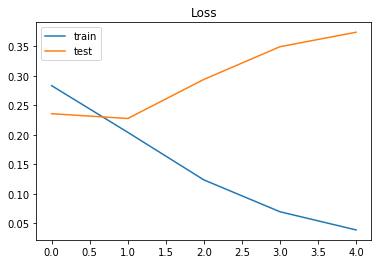

In [516]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

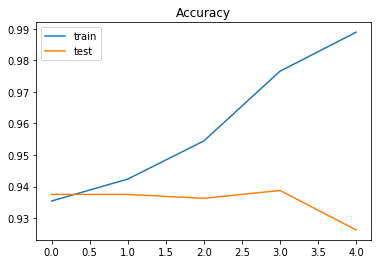

In [517]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

### "Toy" Model Learnings, Design Modification Decisions, and Tuning: 

**Hyperparameters**:
- Use a single layer, set dropout to zero
- Increase number of embedding dimensions (usually 50-500, more for more data)
- Increase hidden dimensions to 50
- Explicitly set batch size to 1
- Changed loss function to Negative Log Linear Loss vs Cross Entropy Loss (and got much better results)
- Set softmax dimensions to 2 (current number of classes)

**Model Design**:
- Preference for Pytorch over Keras
- Stop calling linear layer on each item in lstm_output
    - Instead pass hn once to linear, then run through softmax
    - Call linear layer on hn output of lstm only
- Run training steps (`self.forward`, `self.loss_fcn`, `self.backward`, `self.optimizer.step`) on every comment individually to accumulate loss over epoch
- Call `self.optimizer.zero_grad` to clear gradient at beginning of each epoch vs. end
- Add an unsqueeze(0) to X_vec elements during training (call to `self.forward`) to get (1, `MAX_SEQUENCE_LENGTH`), returning (`BATCH_SIZE`, 1, `NUM_CLASSES`)
- Force dimensions for predictions from call to self.forward from (`BATCH_SIZE`, 1, `NUM_CLASSES`) to (`BATCH_SIZE`, `NUM_CLASSES`) with `.view()` function
- Start using only second index of each y_vec element with added an unsqueeze(0) during training (call to `self.loss_fcn`) to force dimensions from (`NUM_CLASSES`) to `TOXIC_CLASS_VALUE`, or (1).
- Including training and evaluation loops as methods in model class gets a bit unwieldly. In future iterations, move outside model.